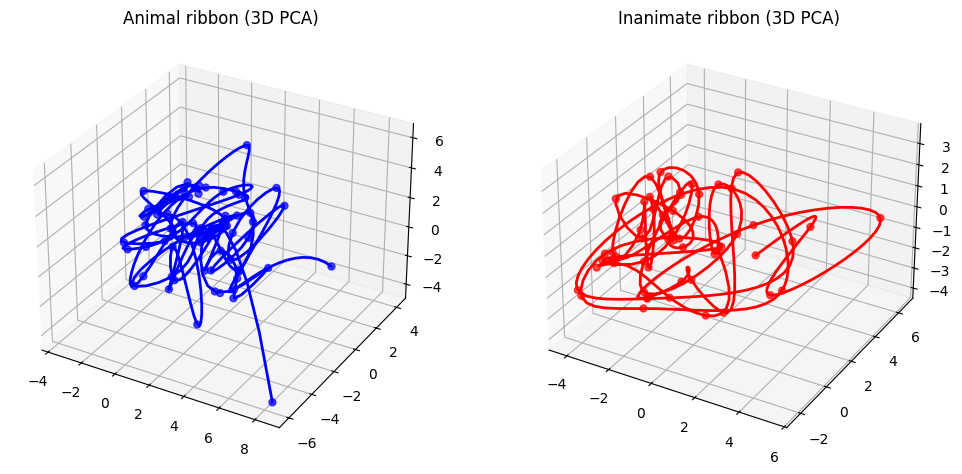

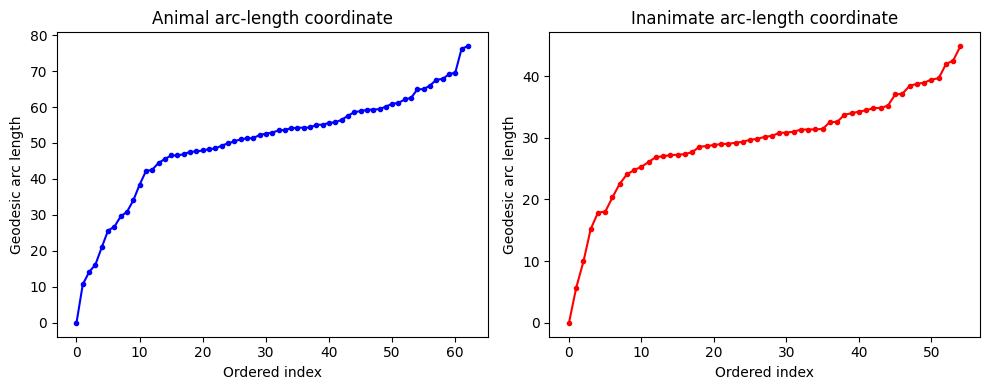

In [ ]:
#https://chatgpt.com/c/692f4e59-35b4-832a-9738-86d6a6c6ccb9

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import minimum_spanning_tree, shortest_path
from scipy.interpolate import splprep, splev

# =========================
# 1. Load data
# =========================
VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

# class split
top1 = np.argmax(vit, axis=1)
image_is_animal = (top1 <= 397)
R_anim = R[image_is_animal]
R_inanim = R[~image_is_animal]

# =========================
# 2. PCA on full data
# =========================
pca = PCA(n_components=10)
X_pca = pca.fit_transform(R)

X_pca_anim = X_pca[image_is_animal]
X_pca_inanim = X_pca[~image_is_animal]

# =========================
# Helper: build MST + arc length
# =========================
def mst_arc_length(X):
    """
    Build MST, compute true geodesic distances, return arc-length ordering.
    """
    D = pairwise_distances(X)
    
    # Minimum spanning tree (geodesic backbone)
    mst = minimum_spanning_tree(D).toarray()
    
    # Convert MST to undirected adjacency
    A = mst + mst.T
    
    # Compute geodesic distances along MST
    dist = shortest_path(A, directed=False)
    
    # Choose root = farthest-from-median heuristic
    root = np.argmax(np.sum(dist, axis=1))
    
    # Sort points by geodesic distance from root
    order = np.argsort(dist[root])
    geodesic_coord = dist[root][order]
    
    return order, geodesic_coord, mst

# =========================
# 3. Compute ribbons A (animal) and B (inanimate)
# =========================
order_anim, t_anim, mst_anim = mst_arc_length(X_pca_anim)
order_inanim, t_inanim, mst_inanim = mst_arc_length(X_pca_inanim)

# Reordered data
X_anim_ord = X_pca_anim[order_anim]
X_inanim_ord = X_pca_inanim[order_inanim]

# =========================
# 4. Fit principal curve (C) using splines
# =========================
def fit_principal_curve(X, smoothing=0.1):
    """
    Fit a principal curve using a spline through PCA-space.
    """
    # t is just index order
    t = np.linspace(0, 1, len(X))
    
    # spline interpolation in 3D
    tck, _ = splprep([X[:,0], X[:,1], X[:,2]], s=smoothing)
    u_fine = np.linspace(0, 1, 400)
    x_s, y_s, z_s = splev(u_fine, tck)
    curve = np.vstack([x_s, y_s, z_s]).T
    return curve

curve_anim = fit_principal_curve(X_anim_ord[:, :3])
curve_inanim = fit_principal_curve(X_inanim_ord[:, :3])

# =========================
# 5. Plot both ribbons in 3D (B)
# =========================
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Animal ribbon (3D PCA)")

ax.scatter(X_anim_ord[:,0], X_anim_ord[:,1], X_anim_ord[:,2],
           c='blue', s=25, alpha=0.7)
ax.plot(curve_anim[:,0], curve_anim[:,1], curve_anim[:,2],
        color='blue', linewidth=2)

ax = fig.add_subplot(122, projection='3d')
ax.set_title("Inanimate ribbon (3D PCA)")

ax.scatter(X_inanim_ord[:,0], X_inanim_ord[:,1], X_inanim_ord[:,2],
           c='red', s=25, alpha=0.7)
ax.plot(curve_inanim[:,0], curve_inanim[:,1], curve_inanim[:,2],
        color='red', linewidth=2)

plt.show()

# =========================
# 6. Plot intrinsic arc-length coordinate (A)
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Animal arc-length coordinate")
plt.plot(t_anim, 'b.-')
plt.xlabel("Ordered index")
plt.ylabel("Geodesic arc length")

plt.subplot(1,2,2)
plt.title("Inanimate arc-length coordinate")
plt.plot(t_inanim, 'r.-')
plt.xlabel("Ordered index")
plt.ylabel("Geodesic arc length")

plt.tight_layout()
plt.show()
